## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Calibrate Camera 

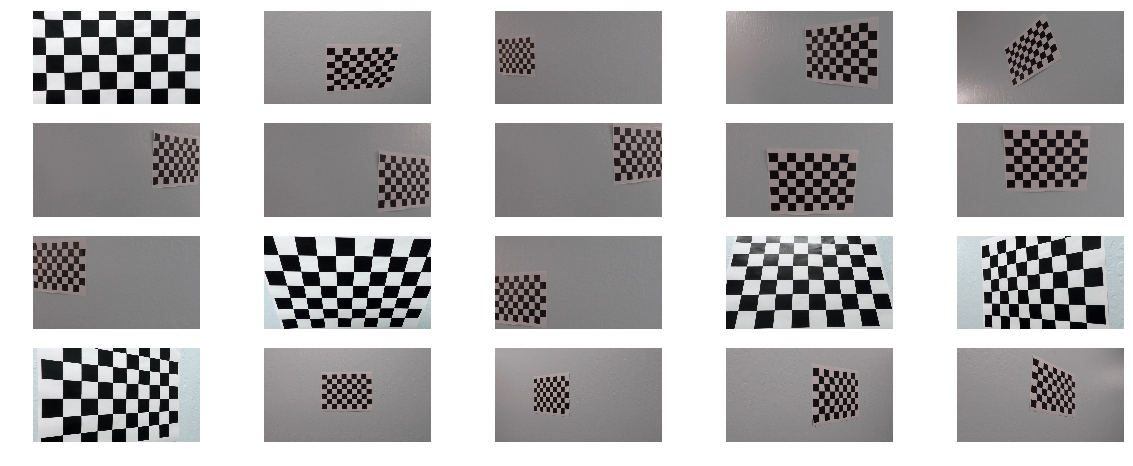

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

# Performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    undist = np.copy(img)  # Delete this line
    return undist

# Verify images come out undistorted
plt.figure(figsize=(20,10))
i=1
for filename in images:
    plt.subplot(5, 5, i)
    i+=1
    plt.axis('off')
    # plt.title("Class %s" % label)
    image = cv2.imread(filename)
    image = cal_undistort(image, objpoints, imgpoints)
    plt.imshow(image.squeeze())
plt.show()

## Helper Methods

In [ ]:
# Define a function that applies Sobel x or y,
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))

    # 5) Create a mask of 1's where the scaled gradient magnitude
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image

    return sbinary


# Define a function that applies Sobel x and y,
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Calculate the magnitude
    magnitude = np.sqrt(sobelx ** 2 + sobely ** 2)
    print(magnitude)

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_mag = np.uint8(255 * magnitude / np.max(magnitude))

    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1

    return binary_output


# Define a function that applies Sobel x and y,
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)

    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    graddir = np.arctan2(abs_sobely, abs_sobelx)

    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(graddir)
    binary_output[(graddir >= thresh[0]) & (graddir <= thresh[1])] = 1

    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1

    return binary_output